<a href="https://colab.research.google.com/github/kaung-htet-myat/Multi-teachers-Knowledge-Distillation/blob/master/Uncertainty_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import scipy as sp
from scipy.stats import entropy
import matplotlib.pyplot as plt

from nets.keras_resnet import resnet_v1, resnet_v2
from nets.student_model_multeacherKD import resnet20_student

## Functions

In [0]:
def JS_Divergence(softmaxes):
  softsum = np.zeros(softmaxes[0].shape)
  jsd = 0.0
  n = len(softmaxes)

  for i in softmaxes:
    j = np.asarray(i) 
    j = j/j.sum()
    softsum += j

  m = 1./n*softsum

  for i in softmaxes:
    j = np.asarray(i)
    jsd += sp.stats.entropy(j,m, base=np.e)/n

  return jsd

In [0]:
def kd_loss(y_true, y_pred):

  '''
    Calculate modified Kullback-Leibler Divergence between ground truths and prediction.
  '''

  y_true_normal = y_true[:,:10]
  y_true_soft = y_true[:,10:]
  y_pred_normal = y_pred[:,:10]
  y_pred_soft = y_pred[:, 10:]

  alpha = 0.5
  t = temperature

  a = tf.keras.losses.kullback_leibler_divergence(y_pred_soft, y_true_soft) # kl divergence between softened logits of teacher and student
  b = tf.keras.losses.categorical_crossentropy(y_pred_normal, y_true_normal) # cross entropy between student's prediction and ground truth label

  return a*(alpha*t*t)+b*(1-alpha)

In [0]:
def multihead_kd_evaluate(y_true, y_pred):

    pred = []
    acc = []
    loss = []
    
    m = tf.keras.metrics.CategoricalAccuracy()

    for i in range(len(y_pred)):
      m(y_true, y_pred[i][:,:10])
      pred.append(y_pred[i][:,:10])
      acc.append(m.result().numpy()) 
      cce = tf.keras.losses.CategoricalCrossentropy()
      loss.append(cce(y_true, y_pred[i][:,:10]).numpy())
      m.reset_states

    pred = np.array(pred)
    avg_pred = pred.mean(axis=0)
    m(y_true, avg_pred)
    avg_acc = m.result().numpy()
    m.reset_states
    
    return (loss,acc, avg_acc)

In [0]:
def new_softmax(logits, temperature=1):

  '''
    temperatured softmax
  '''
  logits = logits/temperature
  return np.exp(logits)/np.sum(np.exp(logits))

In [0]:
def teacher_softmax_extract(model, data):
  softmax = model(data)
  return softmax

## Data Loading

In [0]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()
train_data, test_data = train_data.astype('float32')/255. , test_data.astype('float32')/255.
train_labels, test_labels = train_labels.astype('int32'), test_labels.astype('int32')

x_train_mean = np.mean(train_data, axis=0)
train_data -= x_train_mean
test_data -= x_train_mean

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(train_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Model Loading

In [0]:
resnet_14 = tf.keras.models.load_model('/content/drive/My Drive/MulTeacher Models/resnet_14')
resnet_14.evaluate(test_data, test_labels)

313/313 [==============================] - 23s 72ms/step - loss: 0.5394 - accuracy: 0.8612


[0.5393701195716858, 0.8611999750137329]

In [0]:
resnet_20 = tf.keras.models.load_model('/content/drive/My Drive/MulTeacher Models/resnet_20')
resnet_20.evaluate(test_data, test_labels)

313/313 [==============================] - 93s 297ms/step - loss: 0.5051 - accuracy: 0.8766


[0.5051367878913879, 0.8766000270843506]

In [0]:
resnet_32 = tf.keras.models.load_model('/content/drive/My Drive/MulTeacher Models/resnet_32')
resnet_32.evaluate(test_data, test_labels)

313/313 [==============================] - 126s 401ms/step - loss: 0.5683 - accuracy: 0.8672


[0.5682622194290161, 0.8672000169754028]

In [0]:
resnet_44 = tf.keras.models.load_model('/content/drive/My Drive/MulTeacher Models/resnet_44')
resnet_44.evaluate(test_data, test_labels)

313/313 [==============================] - 70s 225ms/step - loss: 0.5796 - accuracy: 0.8735


[0.5796104073524475, 0.8734999895095825]

In [0]:
temperature = 4
student = resnet20_student((32,32,3), temperature=temperature, num_classes=10)
student.load_weights('/content/drive/My Drive/MulTeacher Models/students/combined_cp/cp.ckpt')

pred = student(test_data)
(loss, acc, avg_acc) = multihead_kd_evaluate(test_labels, pred)
print(acc, avg_acc)

[0.8406, 0.8371, 0.83743334, 0.83605] 0.83622


## Softmax Extraction

In [0]:
# Teacher Softmaxes

teacher_models = [resnet_14, resnet_20, resnet_32, resnet_44]

teacher_softmaxes = [model(test_data[:1000]) for model in teacher_models]

teacher_softmaxes = np.array(teacher_softmaxes)

teacher_softmaxes = teacher_softmaxes.transpose((1,0,2))

print(teacher_softmaxes.shape)

(1000, 4, 10)


In [0]:
# Student Softmaxes

student_softmax = student(test_data[:1000])

student_softmax = np.array(student_softmax)

student_softmax = student_softmax.transpose((1,0,2))

print(student_softmax.shape)

(1000, 4, 20)


## Divergence Value Calculation

1. Calculate teacher disagreement
2. Take top ten instances with highest teacher disagreement
3. Plot teacher softmaxes
4. Plot teacher+student softmaxes on each head
5. Calculate student disagreement on ten instances from step 2
6. Calculate divergence between each teacher and student head for ten instances from step 2
7. Calculate average divergence between each teacher and student head over all instances

In [0]:
teacher_divs = [JS_Divergence(sm) for sm in teacher_softmaxes]

top_10 = np.sort(teacher_divs)[-10:]
top_10_idx = np.argsort(teacher_divs)[-10:]

low_10 = np.sort(teacher_divs)[:10]
low_10_idx = np.argsort(teacher_divs)[:10]

print(top_10)
print(top_10_idx)

[0.58168455 0.58325735 0.5833997  0.5991317  0.59963804 0.6571915
 0.69967436 0.72947931 0.75419335 0.83429159]
[598 793 458 831 836 178 900 796 710 888]


In [0]:
student_divs = [JS_Divergence(sm) for sm in student_softmax[:,:,:10]]

s_top_10 = np.sort(student_divs)[-10:]
s_top_10_idx = np.argsort(student_divs)[-10:]

s_low_10 = np.sort(student_divs)[:10]
s_low_10_idx = np.argsort(student_divs)[:10]

print(s_top_10)
print(s_top_10_idx)

[0.16123602 0.16610099 0.16628815 0.17400545 0.19095268 0.20533983
 0.20857481 0.22842108 0.25341965 0.26292953]
[426 531 480 882 232 363  49 706 393 655]


## Softmaxes Plotting

In [0]:
def softmax_plotting(t_softmaxes, s_softmax, idx, s_idx):

  top_ten_teacher = t_softmaxes[idx]
  top_ten_student = s_softmax[s_idx]

  t_labels = ['resnet14', 'resnet20', 'resnet32', 'resnet44']
  s_labels = ['head_1', 'head_2', 'head_3', 'head_4']

  fig, axes = plt.subplots(top_ten_teacher.shape[0],top_ten_teacher.shape[1], figsize=(20,25))
  axes = axes.ravel()

  axid = 0
  for i in range(top_ten_teacher.shape[0]):
    for j in range(top_ten_teacher.shape[1]):
      ax = axes[axid]
      ax.bar(range(top_ten_teacher.shape[2]), height= top_ten_teacher[i,j,:], label=t_labels[j], alpha=0.3)
      ax.bar(range(top_ten_student.shape[2]), height= top_ten_student[i,j,:], label=s_labels[j], alpha=0.3)
      ax.legend()
      ax.set_xlabel('class outputs')
      ax.set_ylabel('softmax distributions')
      axid += 1
  plt.show()


## Distributions of teacher and student network outputs over 10 instances with highest <b>Teacher</b> divergence values

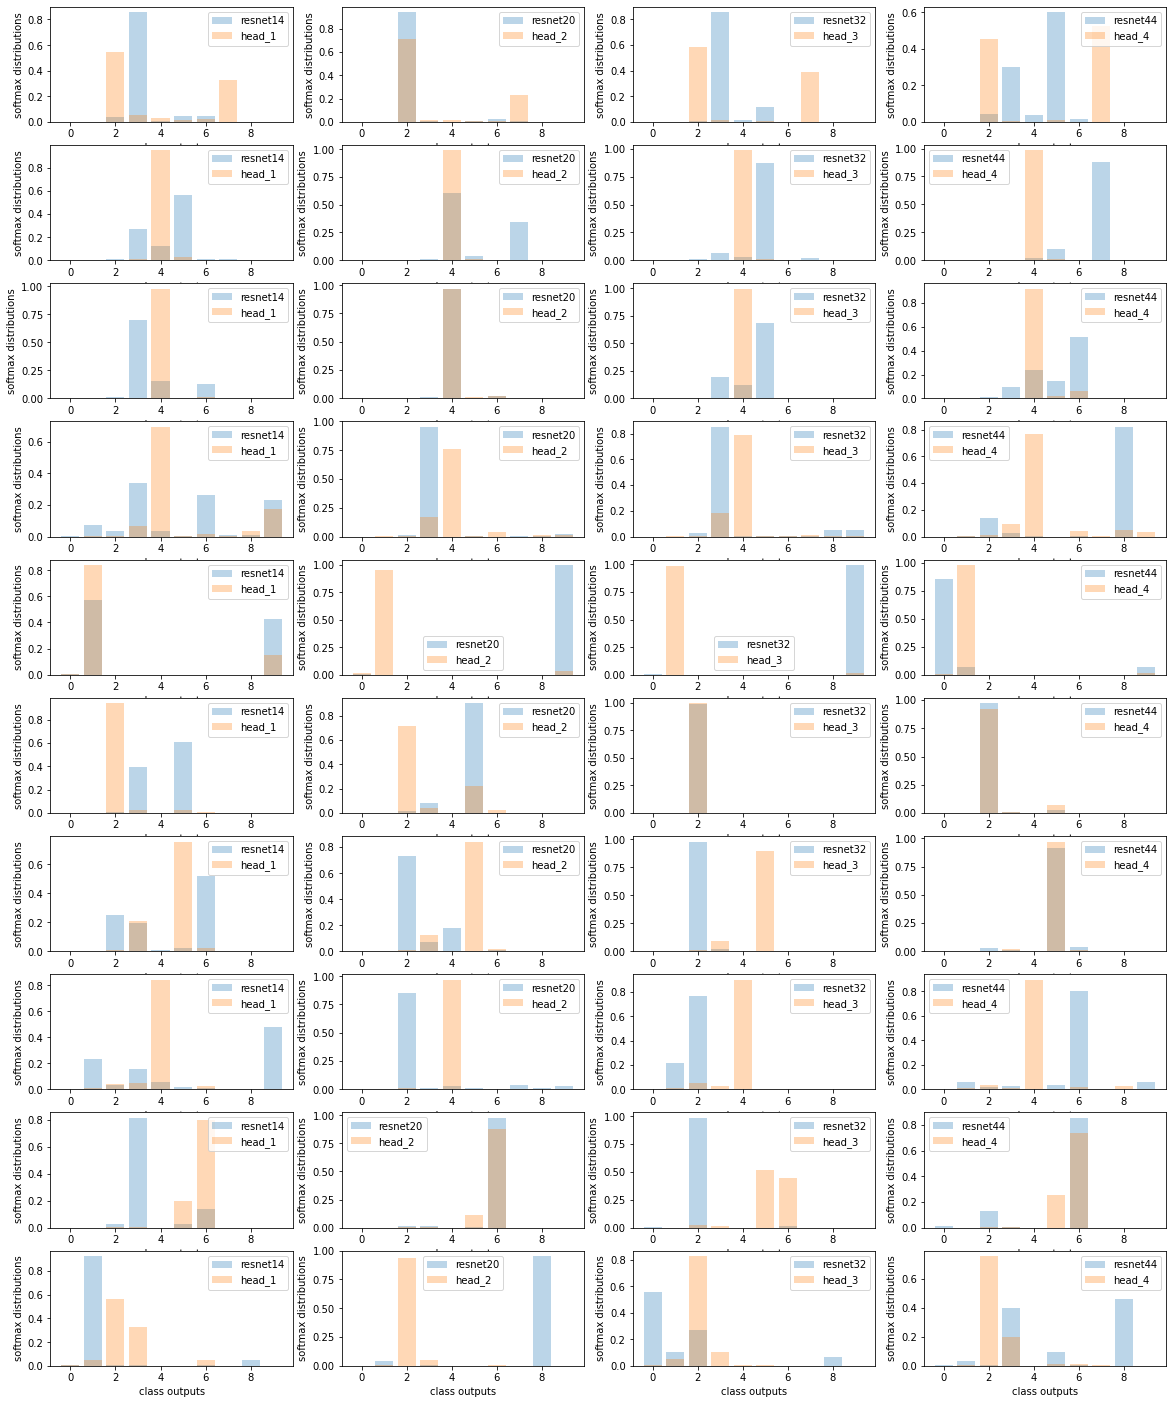

In [0]:
softmax_plotting(teacher_softmaxes, student_softmax[:,:,:10], top_10_idx, top_10_idx)

## Distributions of teacher and student network outputs over 10 instances with highest <b>Student</b> divergence values

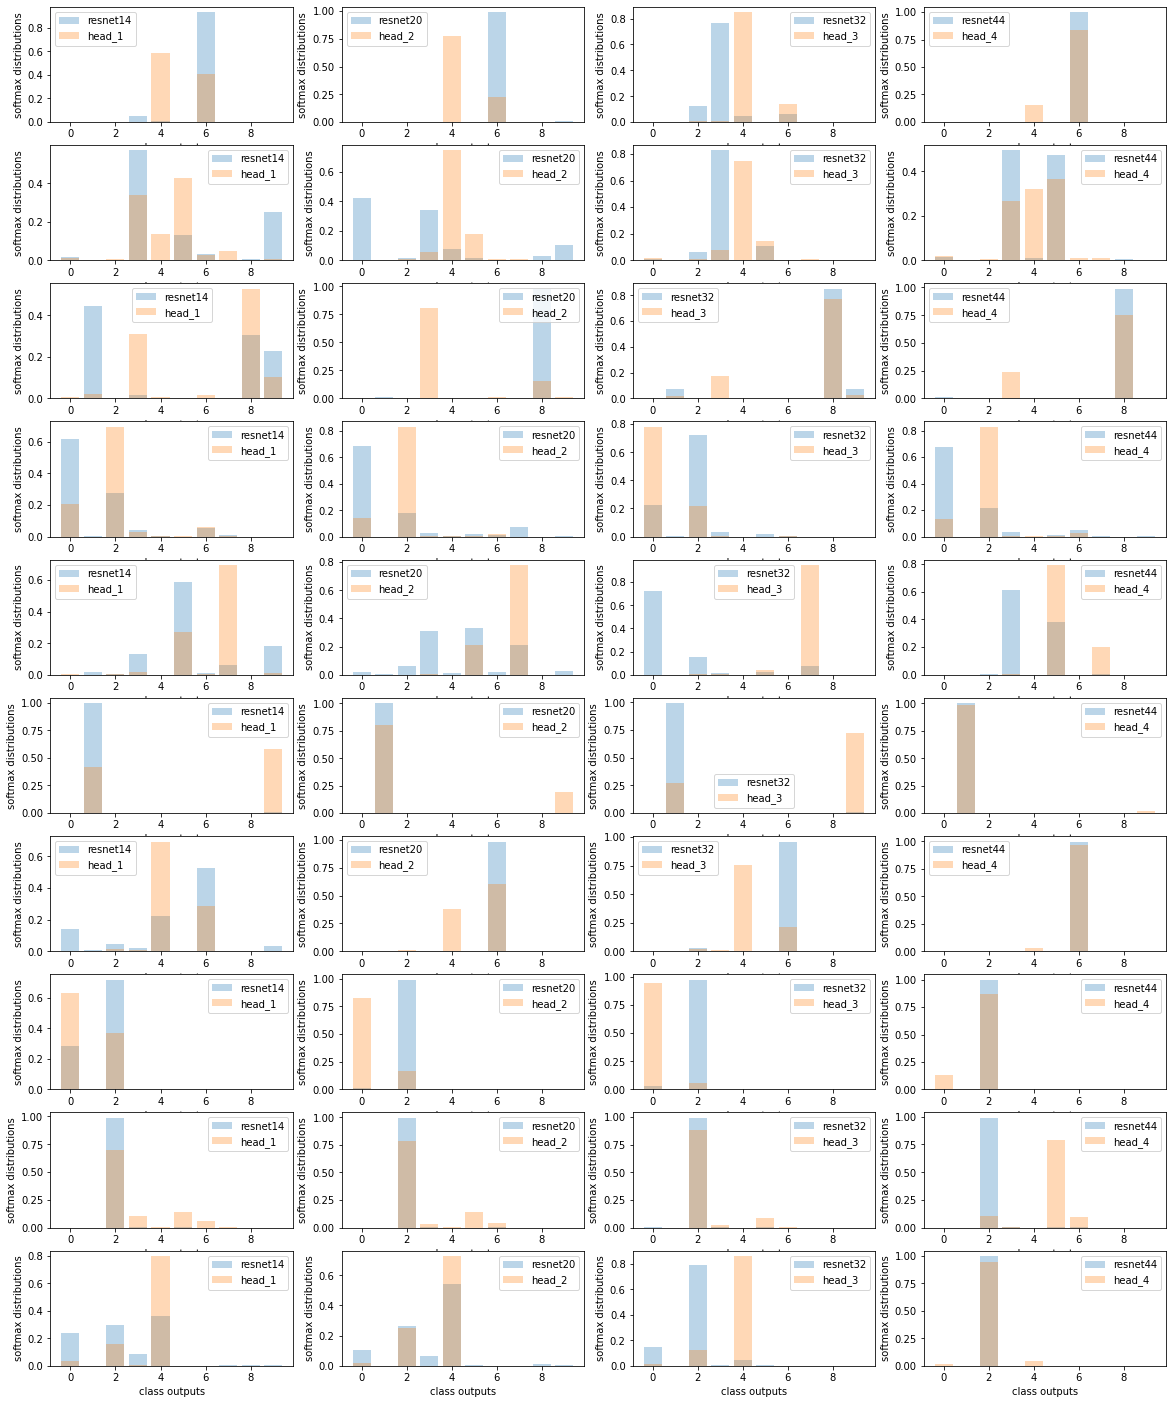

In [0]:
softmax_plotting(teacher_softmaxes, student_softmax[:,:,:10], s_top_10_idx, s_top_10_idx)

## Distributions of teacher and student network outputs over random 10 instances

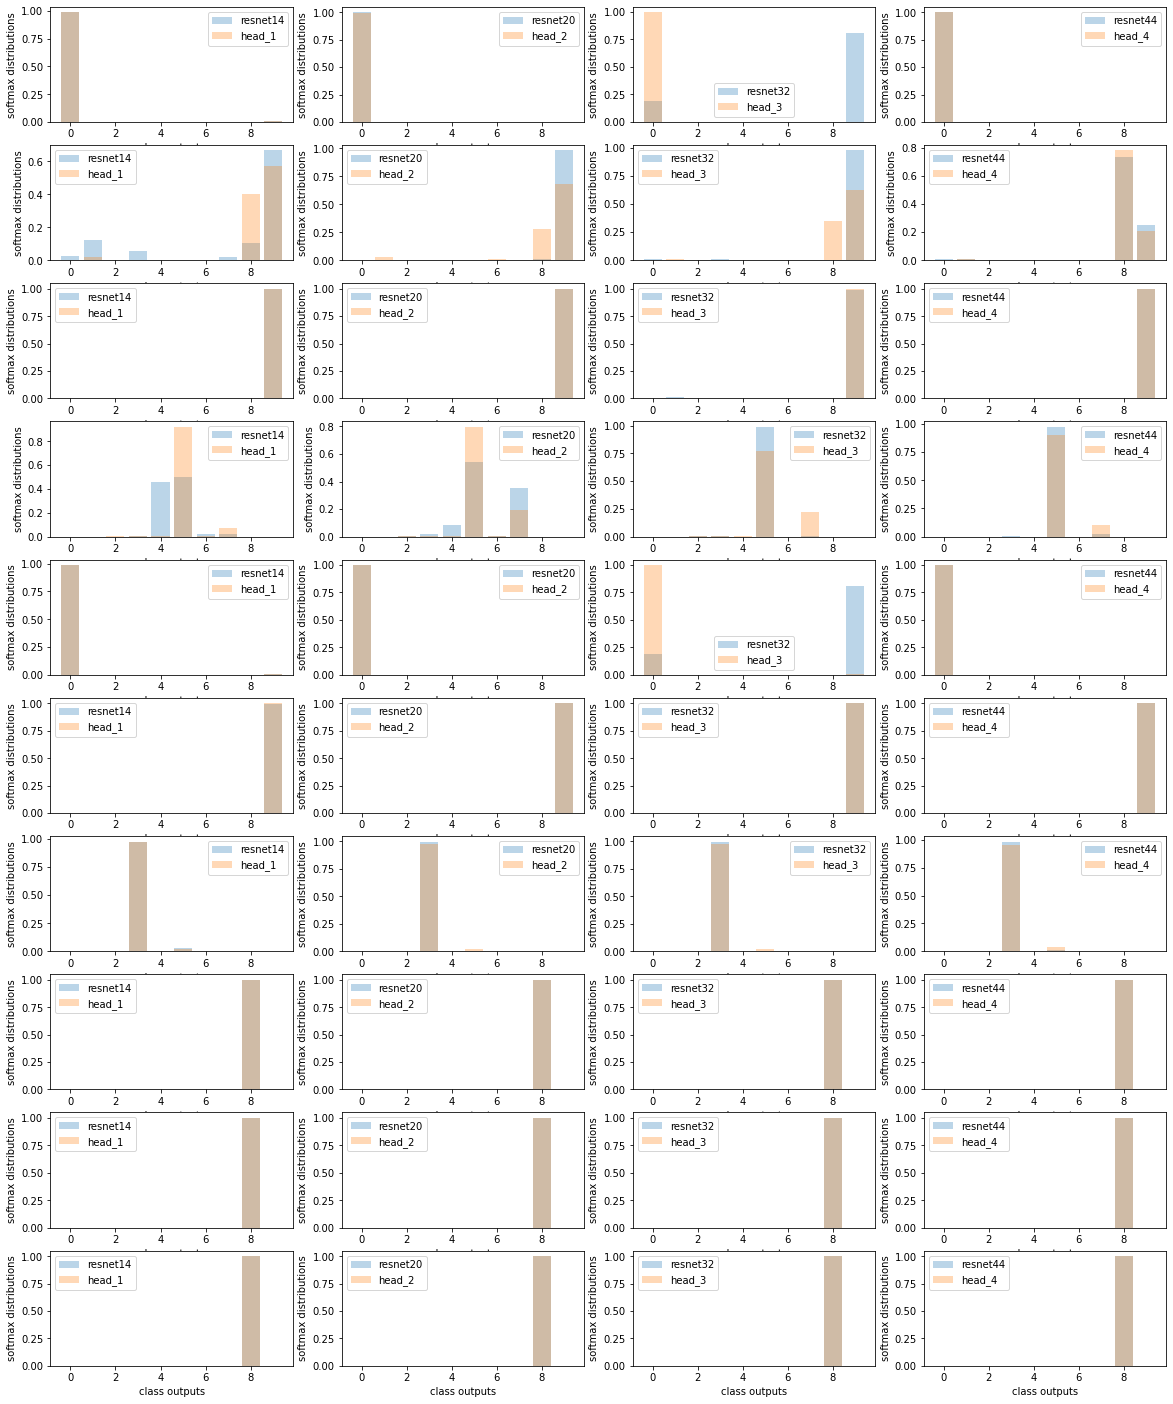

In [0]:
rand_inst = np.random.randint(0, 100, size=10)

softmax_plotting(teacher_softmaxes, student_softmax[:,:,:10], rand_inst, rand_inst)

## Divergence between teacher models and corresponding student heads for 10 instances with highest <b>Teacher</b> divergence value

In [0]:
def divergence_ts_pairs(ts, ss):
  head_divs = []
  for i in range(4):
    head_divs.append(sp.spatial.distance.jensenshannon(ts[i],ss[i][:10]))

  return head_divs

In [0]:
div_ts_pairs = [divergence_ts_pairs(ts, ss) for ts,ss in zip(teacher_softmaxes[top_10_idx], student_softmax[top_10_idx])]

avg_div_pair = np.mean(div_ts_pairs, axis=0)

print(avg_div_pair)

[0.62421544 0.52653993 0.66027477 0.55013596]


## Conclusion
By the visualizations, the student network doesn't seem to be able to capture the teacher's divergence. When teachers diverge, student's heads are quite confident over the output. When the student's heads diverge, teachers are quite confident over the output. <br> Another thing is when the students diverge, only one or two of the heads diverge.<br>
I think it is because my student architecture is big and it could capture the ground truth quite well.<br> I want to test:<br>
1. training with higher alpha value
1. student with smaller architecture
2. student without ground truth
3. try with a different dataset that has more ambiguous data and see how my teachers and student will respond to them
4. re-train all the teacher models to get higher performance and less overfit

<br> There can be bugs around the corners of my code and my implementation so it is also important to compare with other peoples' results